## Machine Learning 

In [1]:
import pandas as pd
import numpy as np
import import_data
import sort_data
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Load the data. We need full curves and one partial curve (that represents the user's curve)

PL03c,PL03d = sort_data.charge_discharge('converted_PL03.mat')
full_curvesc,full_curvesd = sort_data.charge_discharge('converted_PL11.mat')

In [3]:
#Make a shorter partial curve dictionary to uses as train set (because if not the code takes too long)
PL03d_short = {}
for idx in range(1, len(PL03d.keys()), 50):
        if idx in PL03d.keys():
            if idx not in PL03d_short.keys():
                PL03d_short[idx] = PL03d[idx]
PL03d_short.keys()

dict_keys([1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 851, 901, 951, 1001, 1051])

In [4]:
#Make a shorter partial curve dictionary to uses as train set (because if not the code takes too long)
full_curvesd_short = {}
for idx in range(1, len(full_curvesd.keys()), 50):
        if idx in full_curvesd.keys():
            if idx not in full_curvesd_short.keys():
                full_curvesd_short[idx] = full_curvesd[idx]
full_curvesd_short.keys()

dict_keys([1, 51, 101, 151, 201, 251, 301, 351, 401, 501, 551, 601, 651, 701, 751, 801])

In [5]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def curve_distance(a,b):
#Inputs are two nparray    
    distance,path = fastdtw(a, b, dist=euclidean)
    return distance

In [6]:
def distance_cycle_to_full(cycle,dic1,dic2):
#Inputs are 2 dictionaries and the number of cycle that is being tested
    if cycle not in dic1.keys():
        pass
    else:
        
        # These parts here will get the max and min voltages in the partial curves. Also made it so that
        # the partial curves are in 10 s intervals.
        a = dic1[cycle][['voltage']].values.flatten()
        a_max = a.max()
        a_min = a.min()
        a = a[1::2]
        
        Y = []
    
        for idx in tqdm(dic2.keys()):
            if idx in dic2.keys():
                b = dic2[idx][['voltage']].values.flatten()
                if len(b) > 100: #This is to mae sure the full curve has values (check curve 102, it has only 1 value) 
                    # This creates the filter so that we are only looking at values within the partial curve voltages
                    b = dic2[idx][['voltage']].values.flatten()
                    b_max = np.argwhere(b < a_max)[0][0]
                    b_min = np.argwhere(b > a_min)[-1][0]
                    b = b[int(b_max):int(b_min)]
                    
                    d = curve_distance(a,b)
            
                    A = [idx,d]
                    Y.append(A)
                else:
                    pass
            else:
                pass
    df = pd.DataFrame(Y, columns = ['Cycle','Distance'])
    df = df.sort_values(by = ['Distance'])
    
    return df

In [7]:
def partial_to_full(dic1,dic2):
    """dic1 will be the dictionary of the partial data, or the input, dic2 will be the dictionary of the full cycle data"""
    C = []
    D = []
    F = []
    
    for i in tqdm(dic1.keys()):
        df = distance_cycle_to_full(i,dic1,dic2)
        Distance = df['Distance'][df.index[0]]
        Full_cycle = df['Cycle'][df.index[0]]
        C.append(i)
        D.append(Distance)
        F.append(Full_cycle)
       
    #For the model, we need the lists as NumPy arrays
    D = np.array(D)
    C = np.array(C)
    F = np.array(F)
    return D,C,F

In [8]:
D, C, F = partial_to_full(PL03d_short,full_curvesd_short)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [19]:
np.sort(F)

array([101, 101, 101, 101, 101, 101, 101, 151, 151, 251, 251, 301, 301,
       351, 351, 401, 401, 401, 401, 401], dtype=int64)

In [21]:
C

array([   1,   51,  101,  151,  201,  251,  301,  351,  401,  451,  501,
        551,  601,  651,  701,  851,  901,  951, 1001, 1051])

In [20]:
F

array([301, 151, 101, 151, 301, 101, 101, 101, 251, 101, 101, 101, 251,
       351, 351, 401, 401, 401, 401, 401], dtype=int64)

In [9]:
cap = 1.5
Capacity = []
Percent = []
Time = []
Slope = []
Intercept = []
Life = []
for i in range(1,len(F)-1):
    idx = full_curvesd_short[F[i]].shape[0]
    capacity = full_curvesd_short[F[i]]['discharge_ah'][full_curvesd_short[F[i]].index[idx-1]] - full_curvesd_short[F[i]]['discharge_ah'][full_curvesd_short[F[i]].index[0]]
    
    time = PL03d_short[C[i]]['time'][PL03d_short[C[i]].index[PL03d_short[C[i]].shape[0]-1]]
    percent = ((capacity)/cap)*100 #IS THIS EQUATION OK??????                                                   
    #Coeff. for linear regression 
    coeff = np.polyfit([float(0),time],[float(100),percent],1)
    #Calculate the failure time
    life = -coeff[1]/coeff[0]
        
    Capacity.append(capacity)
    Percent.append(percent)
    Time.append(time)
    Slope.append(coeff[0])
    Intercept.append(coeff[1])
    Life.append(life)

In [9]:
def get_lifetime(dic1,dic2,cap):
    
    D,C,F = partial_to_full(dic1,dic2)

    #For the prediction, get the full and partial curves
    
    Capacity = []
    Percent = []
    Time = []
    Slope = []
    Intercept = []
    Life = []
    for i in range(1,len(F)-1):
        idx = dic2[F[i]].shape[0]
        capacity = dic2[F[i]]['discharge_ah'][dic2[F[i]].index[idx-1]] - dic2[F[i]]['discharge_ah'][dic2[F[i]].index[0]]
    
        time = dic1[C[i]]['time'][dic1[C[i]].index[dic1[C[i]].shape[0]-1]]
        percent = ((capacity)/cap)*100                                                    
        #Coeff. for linear regression 
        coeff = np.polyfit([float(0),time],[float(100),percent],1)
        #Calculate the failure time
        life = -coeff[1]/coeff[0]
        
        Capacity.append(capacity)
        Percent.append(percent)
        Time.append(time)
        Slope.append(coeff[0])
        Intercept.append(coeff[1])
        Life.append(life)
    
    return Percent, Time, Slope, Intercept, Life

In [10]:
Percent, Time, Slope, Intercept, Life = get_lifetime(PL03d_short,full_curvesd_short,1.5)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [31]:
def life_plot(time,slope,intercept,percent,life):
    
    fig = plt.figure(figsize = (8, 6))
    x = [time/(3600*24*7),life/(3600*24*7)]
    y = [time*slope + intercept, life*slope + intercept]
    
    x1 = [0,time/(3600*24*7)]
    y1 = [intercept, time*slope + intercept]
   
    plt.plot(x1,y1)
    plt.scatter(time/(3600*24*7),percent)
    plt.plot(x,y,ls = '--')
    plt.ylim(0, 100)
    plt.xlim(0, 52)#life/(3600*24*7))
    plt.title('Life prediction')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Remaining Capacity (%)')
    plt.axhline(y = 80)
    return 

In [26]:
len(Percent)

18

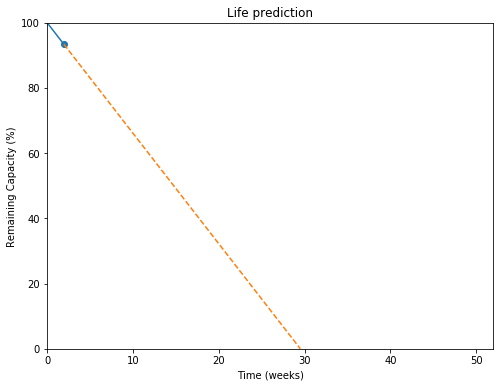

In [23]:
life_plot(Time[1],Slope[1],Intercept[1],Percent[1],Life[1])


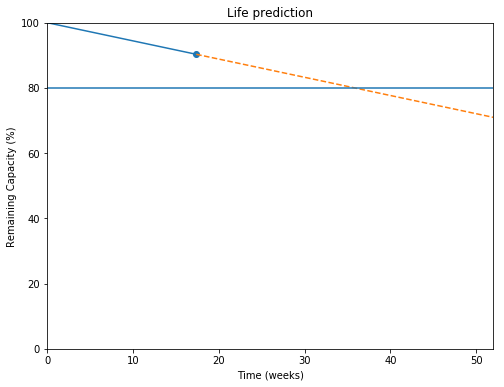

In [32]:
life_plot(Time[17],Slope[17],Intercept[17],Percent[17],Life[17])
